# Computational model for group analysis

### Demo code for Ito et al., 2017. Generates exact figures from Supplementary Fig. 3, and several comparable figures to Fig. 4.

#### Author: Takuya Ito (takuya.ito@rutgers.edu)

#### Ito T, Kulkarni KR, Schultz DH, Mill RD, Chen RH, Solomyak LI, Cole MW (2017). Cognitive task information is transferred between brain regions via resting-state network topology. bioRxiv. https://doi.org/10.1101/101782

**Summary:** Reads in data generated from running simulations on a compute cluster (20 simulations/subjects). For each simulated subject, we run a resting-state simulation, a task-state simulation (for topdown hub stimulation), a second task-state simulation (for simultaneous topdown and bottomup network stimulation), and perform the information transfer mapping procedure for each task. Each task consists for 4 different task conditions.

Simulations are run using a network with five communities, comprising of a single hub community and four local communities. We employ a firing rate code model, and simulate functional MRI data by convolving the simulated signal with a hemodynamic response function (defined in model.py module).

See Supplemental materials/methods for a full description.

## The model (see Stern et al., 2014)

$$ \frac{dx_{i}}{dt} \tau_{i} = -x_{i}(t) + s \hspace{3 pt} \phi \hspace{1 pt} \bigg{(} x_i(t) \bigg{)} + g \bigg{(} \sum_{j\neq i}^{N} W_{ij} \hspace{3 pt} \phi \hspace{1 pt} \bigg{(} x_{j}(t) \bigg{)} \bigg{)} + I_{i}(t)$$

where $x_i$ is the activity of region $i$, $\tau_{i}$ is the time constant for region $i$, $s$ is the recurrent (local) coupling, $g$ is the global coupling parameter, $\phi$ is the bounded transfer function (in this scenario is the hyperbolic tangent), $W_{xy}$ is the synaptic connectivity matrix, and $I$ is the task-stimulation (if any).

# Simulation description (see Methods for full description)
**N.B. All simulations were performed separately using the provided modules; data provided are a direct product for running the provided model. This notebook is configured to run analyses in parallel using the multiprocessing module in python.**

**1.0 Load and visualize synaptic connectivity, resting-state FC**

**2.0 Compute out-of-network degree centrality**

**3.0 Load in network-to-network activity flow mapping predictions; perform predicted-to-actual similarity analysis (RSA)**

**4.0 Seconday analysis: Load in network-to-network activity flow mapping predictions; perform predicted-to-actual similarity analysis (using SVMs) **

#### Parameters:
* global coupling parameter g = 1.0
* local coupling parameter s = 1.0
* Sampling rate of 10ms

#### Additional notes:
* Simulation data was generated using the function model.subjectSimulationAndSaveToFile()
* See help(model.subjectSimulationAndSaveToFile) for more details
* Simulations were performed on a compute cluster at Rutgers University (NM3 compute cluster)
* A single subject simulation takes about ~10-12 minutes to complete for model.subjectSimulationAndSaveToFile



# 0 - Import modules and define essential parameters

In [1]:
import numpy as np
import sys
sys.path.append('../utils/')
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import matplotlib.pyplot as plt
% matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
import multiprocessing as mp
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import statsmodels.sandbox.stats.multicomp as mc
# Import custom modules
import multregressionconnectivity as mreg
import model 
import analysis

from matplotlib.colors import Normalize

# Code to generate a normalized midpoint for plt.imshow visualization function
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#### ESSENTIAL parameters to modify
* Identify data directory
* Indicate number of threads to perform analyses (this originally was performed on a large linux servers with > 20 CPUs)

In [2]:
# Specify the directory to read in provided data
# If data file was unzippd in current working directory this shouldn't need to be changed
datadir = 'ItoEtAl2017_Simulations/'
# Specify number of CPUs to process on (using multiprocessing module in python)
nproc = 10
# Output file to save generated figures (from this notebook)
outputdir = './figures/' # default with output in current working directory
if not os.path.exists(outputdir): os.makedirs(outputdir)

** Basic simulation parameters **

In [3]:
nsubjs = range(0,20) # number of simulations (i.e., subject numbers)
nblocks = 20 # number of blocks per task condition

#### Define the condition numbers associated with each task
# Conditions 1-4 are for top-down stimulation only (i.e., task 1)
topdown_only = range(1,5)
# Conditions 5-9 are simultaneous top-down (hub-network) and bottom-up (local-network) stimulation (i.e., task 2)
topdown_and_bottomup = range(5,9)


# 1.0 Construct sample network matrix and visualize group FC matrices

## 1.1 Construct and visualize synaptic matrix for a single sample subject (Fig. 4A)

We generate a random synaptic matrix using the model.py module for demonstration

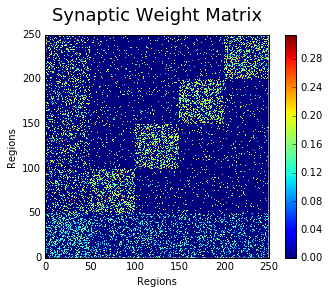

In [4]:
#### Set up subject networks ####
# Parameters for subject's networks
ncommunities = 5
innetwork_dsity = .35
outnetwork_dsity = .05
hubnetwork_dsity = .20

nodespercommunity = 50
totalnodes = nodespercommunity*ncommunities

##########
# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities, innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity, hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity, showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=False)

# Define community affiliation vector
Ci = np.repeat(np.arange(ncommunities),nodespercommunity)

# Plot figure
plt.figure()
# norm = MidpointNormalize(midpoint=0)
plt.imshow(G,origin='lower',interpolation='none')
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.title('Synaptic Weight Matrix', y=1.04, fontsize=18)
plt.colorbar()

## 1.2 Visualize group average resting-state FC from simulated data (analogous to Fig. 4B)
#### Visualize both Pearson FC and multiple linear regression

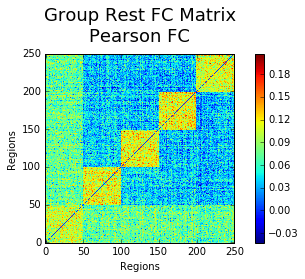

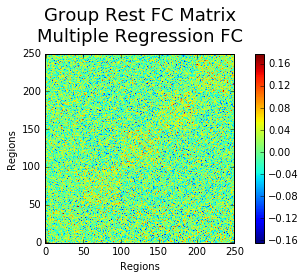

In [5]:
fcmat_pearson = np.zeros((totalnodes,totalnodes,len(nsubjs)))
fcmat_multreg = np.zeros((totalnodes,totalnodes,len(nsubjs)))

##########
# Load in subject FC data
scount = 0
for subj in nsubjs:
    indir = datadir + '/restfc/'
    # Load in pearson FC matrix
    filename1 = 'subj' + str(subj) + '_restfc_pearson.txt'
    fcmat_pearson[:,:,scount] = np.loadtxt(indir + filename1, delimiter=',')
    # Loda in multreg FC matrix
    filename2 = 'subj' + str(subj) + '_restfc_multreg.txt'
    fcmat_multreg[:,:,scount] = np.loadtxt(indir + filename2, delimiter=',')
    
    scount += 1
    
##########
# Plot group FC averages
plt.figure()
avg = np.mean(fcmat_pearson,axis=2)
np.fill_diagonal(avg,0)
plt.imshow(avg ,origin='lower',interpolation='none')#,vmin=0)
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.title('Group Rest FC Matrix\nPearson FC', y=1.04, fontsize=18)
plt.colorbar()
plt.tight_layout()

plt.figure()
avg = np.mean(fcmat_multreg,axis=2)
np.fill_diagonal(avg,0)
plt.imshow(avg ,origin='lower',interpolation='none')#,vmin=-.08,vmax=.08)
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.title('Group Rest FC Matrix\nMultiple Regression FC', y=1.04, fontsize=18)
plt.colorbar()
plt.tight_layout()


# 2.0 Compute out-of-network intrinsic FC (analogous to Fig. 4D)

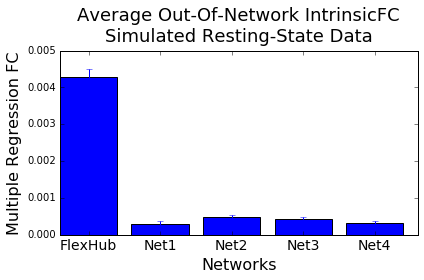

In [6]:
outofnet_intrinsicFC = np.zeros((ncommunities,len(nsubjs)))
indices = np.arange(nodespercommunity*ncommunities)

##########
# Calculate average out-of-network degree across subjects
scount = 0
for subj in nsubjs:
    for net in range(0,ncommunities):
    #     if net == hubnet: continue 
        net_ind = np.where(Ci==net)[0]
        net_ind.shape = (len(net_ind),1)
        outofnet_ind = np.setxor1d(net_ind,indices)
        outofnet_ind.shape = (len(outofnet_ind),1)
        outofnet_intrinsicFC[net,scount] =  np.mean(fcmat_multreg[net_ind, outofnet_ind.T, scount])
        
    scount += 1
    
# Compute average stats
fcmean = np.mean(outofnet_intrinsicFC,axis=1)
fcerr = np.std(outofnet_intrinsicFC,axis=1)/np.sqrt(len(nsubjs))
    
##########
# Plot figure
fig = plt.bar(range(len(fcmean)), fcmean, yerr=fcerr)
# fig = plt.ylim([.09,0.10])
fig = plt.xticks(np.arange(.4,5.4,1.0),['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'],fontsize=14)
fig = plt.ylabel('Multiple Regression FC', fontsize=16)
fig = plt.xlabel('Networks', fontsize=16)
fig = plt.title("Average Out-Of-Network IntrinsicFC\nSimulated Resting-State Data", fontsize=18, y=1.02)
fig = plt.tight_layout()

# 3.0 Run group analysis on network-to-network information transfer mapping output using simulated data (Supplementary Fig. 3A-D)

#### Note: Activity flow mapping procedure (and subsequent data) was generated on the compute cluster. Code that generated data is included in model.py. We demonstrate the 'predicted-to-actual' similarity analysis below.

## 3.1 Network-to-network information transfer mapping on simulated neural data

Region-to-region activity flow mapping is performed already (with provided simulation data); we only perform the predicted-to-actual similarity analysis.

* Perform for two tasks: (1) topdown only task conditions (stimulation of hub network only); (2) topdown and bottom up task conditions (stimulation of both hub network and local networks).

In [7]:
# Empty variables for topdown task analysis
ite_topdown = np.zeros((ncommunities,ncommunities,len(nsubjs)))
# Empty variables for topdown and bottomup task analysis
ite_topdownbottomup = np.zeros((ncommunities,ncommunities,len(nsubjs)))

##########
# Run predicted-to-actual similarity for every network-to-network configuration (using RSA approach)
for i in range(ncommunities):
    for j in range(ncommunities):
        if i==j: continue
        fromnet = i
        net = j
        nblocks = nblocks
        
        ## First run on topdown only task conditions
        inputs = []
        for subj in nsubjs: inputs.append((subj,net,fromnet,topdown_only,nblocks,Ci,nodespercommunity,datadir))
        # Run multiprocessing across subjects
        pool = mp.Pool(processes=nproc)
        results_topdown = pool.map_async(analysis.predictedToActualRSA, inputs).get()
        pool.close()
        pool.join()
        
        ## Second run on topdown and bottomup task conditions
        inputs = []
        for subj in nsubjs: inputs.append((subj,net,fromnet,topdown_and_bottomup,nblocks,Ci,nodespercommunity,datadir))
        # Run multiprocessing
        pool = mp.Pool(processes=nproc)
        results_topdownbottomup = pool.map_async(analysis.predictedToActualRSA, inputs).get()
        pool.close()
        pool.join()
        

        ## Get results and store in network X network X subjects matrix
        scount = 0
        for subj in nsubjs:
            # Obtain topdown task results
            ite = results_topdown[scount]
            ite_topdown[i,j,scount] = ite
            # Obtain topdown and bottom up task results
            ite = results_topdownbottomup[scount]
            ite_topdownbottomup[i,j,scount] = ite
            
            scount += 1


## 3.2 Statistical testing on results and plot

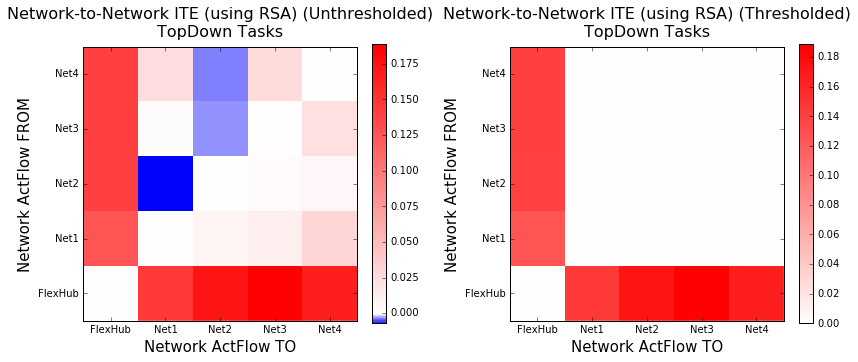

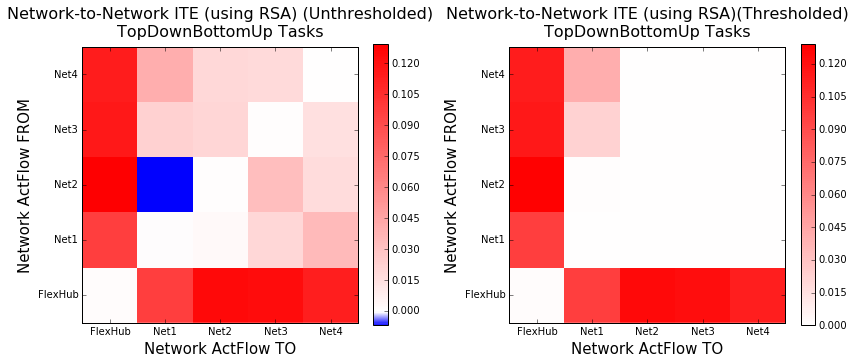

In [8]:
# Instantiate empty result matrices
tmat_topdown = np.zeros((ncommunities,ncommunities))
pmat_topdown = np.ones((ncommunities,ncommunities))
tmat_topdownbottomup = np.zeros((ncommunities,ncommunities))
pmat_topdownbottomup = np.ones((ncommunities,ncommunities))

# Run t-tests for every network-to-network configuration
for i in range(ncommunities):
    for j in range(ncommunities):
        if i==j: continue
        
        ##########
        ## Run statistical test for first task (topdown only stim)
        t, p = stats.ttest_1samp(ite_topdown[i,j,:],0)
        tmat_topdown[i,j] = t
        # Make p-value one-sided (for one-sided t-test)
        if t > 0:
            p = p/2.0
        else:
            p = 1-p/2.0
        pmat_topdown[i,j] = p
        
        ##########
        ## Run statistical test for second task (topdown and bottomup stim)
        t, p = stats.ttest_1samp(ite_topdownbottomup[i,j,:],0)
        # Make p-value one-sided (for one-sided t-test)
        tmat_topdownbottomup[i,j] = t
        if t > 0:
            p = p/2.0
        else:
            p = 1-p/2.0
        pmat_topdownbottomup[i,j] = p

##########
# Run FDR correction on p-values (exclude diagonal values)

## TopDown Task
qmat_topdown = np.ones((ncommunities,ncommunities))
triu_ind = np.triu_indices(ncommunities,k=1)
tril_ind = np.tril_indices(ncommunities,k=-1)
all_ps = np.hstack((pmat_topdown[triu_ind],pmat_topdown[tril_ind]))
h, all_qs = mc.fdrcorrection0(all_ps)
# the first half of all qs belong to triu, second half belongs to tril
qmat_topdown[triu_ind] = all_qs[:len(triu_ind[0])]
qmat_topdown[tril_ind] = all_qs[len(tril_ind[0]):]
binary_mat_topdown = qmat_topdown < .05

## TopDown and BottomUp Task
qmat_topdownbottomup = np.ones((ncommunities,ncommunities))
triu_ind = np.triu_indices(ncommunities,k=1)
tril_ind = np.tril_indices(ncommunities,k=-1)
all_ps = np.hstack((pmat_topdownbottomup[triu_ind],pmat_topdownbottomup[tril_ind]))
h, all_qs = mc.fdrcorrection0(all_ps)
# the first half of all qs belong to triu, second half belongs to tril
qmat_topdownbottomup[triu_ind] = all_qs[:len(triu_ind[0])]
qmat_topdownbottomup[tril_ind] = all_qs[len(tril_ind[0]):]
binary_mat_topdownbottomup = qmat_topdownbottomup < .05

##########
# Plot figures for topdown task
# (Unthresholded plot)
plt.figure(figsize=(12,10))
plt.subplot(121)
norm = MidpointNormalize(midpoint=0)
plt.imshow(np.mean(ite_topdown,axis=2),norm=norm,origin='lower',interpolation='None',cmap='bwr')
plt.title('Network-to-Network ITE (using RSA) (Unthresholded)\nTopDown Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)

# (Thresholded plot)
plt.subplot(122)
threshold_acc = np.multiply(binary_mat_topdown,np.mean(ite_topdown,axis=2))
norm = MidpointNormalize(midpoint=0)
plt.imshow(threshold_acc,norm=norm,origin='lower',interpolation='None',cmap='bwr')
plt.title('Network-to-Network ITE (using RSA) (Thresholded)\nTopDown Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)
plt.tight_layout()
plt.savefig(outputdir + 'SFig_CompModel_RSA_topdownOnly.pdf')


##########
# Plot figures for topdown and bottomup task 
# (Unthresholded plot)
plt.figure(figsize=(12,10))
((12,10))
plt.subplot(121)
norm = MidpointNormalize(midpoint=0)
plt.imshow(np.mean(ite_topdownbottomup,axis=2),origin='lower',interpolation='None',norm=norm,cmap='bwr')
plt.title('Network-to-Network ITE (using RSA) (Unthresholded)\nTopDownBottomUp Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)

# (Thresholded plot)
plt.subplot(122)
threshold_acc = np.multiply(binary_mat_topdownbottomup,np.mean(ite_topdownbottomup,axis=2))
norm = MidpointNormalize(midpoint=0)
plt.imshow(threshold_acc,origin='lower',interpolation='None',norm=norm,cmap='bwr')
plt.title('Network-to-Network ITE (using RSA)(Thresholded)\nTopDownBottomUp Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)
plt.tight_layout()
plt.savefig(outputdir + 'SFig_CompModel_RSA_topdownbottomup.pdf')



# 4.0 Run group analysis on network-to-network information transfer mapping output using SVM decoding (as opposed to predicted-to-actual RSA analysis) (Supplementary Fig. 3E-H)



## 4.1 Network-to-network information transfer mapping on simulated neural data USING SVMs

In [9]:
# Empty variables for topdown task analysis
svm_topdown = np.zeros((ncommunities,ncommunities,len(nsubjs)))
# Empty variables for topdown and bottomup task analysis
svm_topdownbottomup = np.zeros((ncommunities,ncommunities,len(nsubjs)))

##########
# Run predicted-to-actual similarity for every network-to-network configuration (using RSA approach)
for i in range(ncommunities):
    for j in range(ncommunities):
        if i==j: continue
        fromnet = i
        net = j
        nblocks = nblocks
        
        ## First run on topdown only task conditions
        inputs = []
        for subj in nsubjs: inputs.append((subj,net,fromnet,topdown_only,nblocks,Ci,nodespercommunity,datadir))
        # Run multiprocessing across subjects
        pool = mp.Pool(processes=nproc)
        results_topdown = pool.map_async(analysis.predictedToActualSVM, inputs).get()
        pool.close()
        pool.join()
        
        ## Second run on topdown and bottomup task conditions
        inputs = []
        for subj in nsubjs: inputs.append((subj,net,fromnet,topdown_and_bottomup,nblocks,Ci,nodespercommunity,datadir))
        # Run multiprocessing
        pool = mp.Pool(processes=nproc)
        results_topdownbottomup = pool.map_async(analysis.predictedToActualSVM, inputs).get()
        pool.close()
        pool.join()
        

        ## Get results and store in network X network X subjects matrix
        scount = 0
        for subj in nsubjs:
            # Obtain topdown task results
            svm = results_topdown[scount]
            svm_topdown[i,j,scount] = svm
            # Obtain topdown and bottom up task results
            svm = results_topdownbottomup[scount]
            svm_topdownbottomup[i,j,scount] = svm
            
            scount += 1


## 4.2 Statistical testing on results and plot

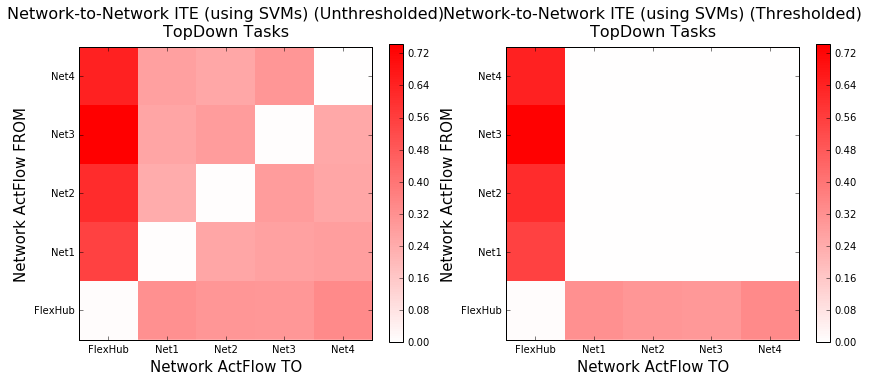

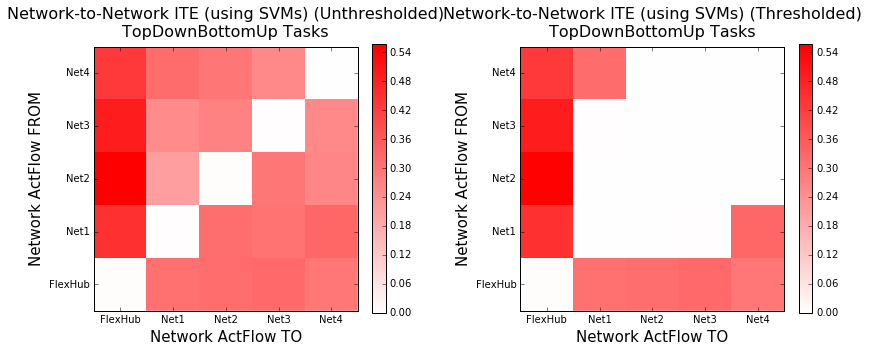

In [10]:
# Instantiate empty result matrices
tmat_topdown_svm = np.zeros((ncommunities,ncommunities))
pmat_topdown_svm = np.ones((ncommunities,ncommunities))
tmat_topdownbottomup_svm = np.zeros((ncommunities,ncommunities))
pmat_topdownbottomup_svm = np.ones((ncommunities,ncommunities))

# Perform accuracy decoding t-test against chance, which is 25% for a 4-way classification
chance = .25 
for i in range(ncommunities):
    for j in range(ncommunities):
        if i==j: continue
        # Run statistical test for first task (topdown only stim)
        t, p = stats.ttest_1samp(svm_topdown[i,j,:],chance)
        tmat_topdown_svm[i,j] = t
        # Make p-value one-sided (for one-sided t-test)
        if t > 0:
            p = p/2.0
        else:
            p = 1-p/2.0
        pmat_topdown_svm[i,j] = p
        # Run statistical test for second task (topdown and bottomup stim)
        t, p = stats.ttest_1samp(svm_topdownbottomup[i,j,:],chance)
        tmat_topdownbottomup_svm[i,j] = t
        # Make p-value one-sided (for one-sided t-test)
        if t > 0:
            p = p/2.0
        else:
            p = 1-p/2.0
        pmat_topdownbottomup_svm[i,j] = p


## TopDown Tasks
# Run FDR correction on p-values (Don't get diagonal values)
qmat_topdown_svm = np.ones((ncommunities,ncommunities))
triu_ind = np.triu_indices(ncommunities,k=1)
tril_ind = np.tril_indices(ncommunities,k=-1)
all_ps = np.hstack((pmat_topdown_svm[triu_ind],pmat_topdown_svm[tril_ind]))
h, all_qs = mc.fdrcorrection0(all_ps)
# the first half of all qs belong to triu, second half belongs to tril
qmat_topdown_svm[triu_ind] = all_qs[:len(triu_ind[0])]
qmat_topdown_svm[tril_ind] = all_qs[len(tril_ind[0]):]
binary_mat_topdown_svm = qmat_topdown_svm < .05

## TopDown and BottomUp Tasks
# Run FDR correction on p-values (Don't get diagonal values)
qmat_topdownbottomup_svm = np.ones((ncommunities,ncommunities))
triu_ind = np.triu_indices(ncommunities,k=1)
tril_ind = np.tril_indices(ncommunities,k=-1)
all_ps = np.hstack((pmat_topdownbottomup_svm[triu_ind],pmat_topdownbottomup_svm[tril_ind]))
h, all_qs = mc.fdrcorrection0(all_ps)
# the first half of all qs belong to triu, second half belongs to tril
qmat_topdownbottomup_svm[triu_ind] = all_qs[:len(triu_ind[0])]
qmat_topdownbottomup_svm[tril_ind] = all_qs[len(tril_ind[0]):]
binary_mat_topdownbottomup_svm = qmat_topdownbottomup_svm < .05

####
## Plot figures for Top Down Task
# Unthresholded map
plt.figure(figsize=(12,10))
plt.subplot(121)
mat = np.mean(svm_topdown,axis=2)
norm = MidpointNormalize(midpoint=0)
plt.imshow(mat,norm=norm,origin='lower',interpolation='None',cmap='bwr')
plt.title('Network-to-Network ITE (using SVMs) (Unthresholded)\nTopDown Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=0.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)
plt.tight_layout()
plt.savefig(outputdir + 'SFig_CompModel_SVM_topdownOnly_Unthresholded.pdf')
# Thresholded map
plt.subplot(122)
mat = np.mean(svm_topdown,axis=2)
mat = np.multiply(binary_mat_topdown_svm,mat)
norm = MidpointNormalize(midpoint=0)
plt.imshow(mat,norm=norm,origin='lower',interpolation='None',cmap='bwr')
plt.title('Network-to-Network ITE (using SVMs) (Thresholded)\nTopDown Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=0.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)
plt.tight_layout()
plt.savefig(outputdir + 'SFig_CompModel_SVM_topdownOnly.pdf')

####
## Plot figures for Top Down AND Bottom Up Task
# Unthresholded map
plt.figure(figsize=(12,10))
plt.subplot(121)
mat = np.mean(svm_topdownbottomup,axis=2)
norm = MidpointNormalize(midpoint=0)
plt.imshow(mat,origin='lower',interpolation='None',norm=norm,cmap='bwr')
plt.title('Network-to-Network ITE (using SVMs) (Unthresholded)\nTopDownBottomUp Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=0.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)
# Thresholded map
plt.subplot(122)
mat = np.mean(svm_topdownbottomup,axis=2)
mat = np.multiply(binary_mat_topdownbottomup_svm,mat)
norm = MidpointNormalize(midpoint=0)
plt.imshow(mat,origin='lower',interpolation='None',norm=norm,cmap='bwr')
plt.title('Network-to-Network ITE (using SVMs) (Thresholded)\nTopDownBottomUp Tasks',fontsize=16, y=1.02)
plt.colorbar(fraction=0.046)
plt.yticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.xticks(range(ncommunities), ['FlexHub', 'Net1', 'Net2', 'Net3', 'Net4'])
plt.ylabel('Network ActFlow FROM',fontsize=15)
plt.xlabel('Network ActFlow TO',fontsize=15)
plt.tight_layout()
plt.savefig(outputdir + 'SFig_CompModel_SVM_topdownbottomup.pdf')

